# Feature Selection for Drug Overdose Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy 
import math

pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load CSV Files into Pandas DataFrames
The csv files are names as follows for each state:
* `{state}0.csv` - Introduction
* `{state}1.csv` - Outcomes & Factors Rankings
* `{state}2.csv` - Outcomes & Factors SubRankings
* `{state}3.csv` - Ranked Measure Data
* `{state}4.csv` - Additional Measure Data
* `{state}5.csv` - Ranked Measure Sources & Years
* `{state}6.csv` - Addtl Measure Sources & Years

In [2]:
states = ['alabama', 'florida', 'louisiana', 'nebraska', 'oklahoma', 'vermont', 'alaska', 
          'georgia', 'maine', 'nevada', 'oregon', 'virginia', 'arizona', 'hawaii', 
          'maryland', 'new-hampshire', 'pennsylvania', 'washington', 'arkansas', 'idaho',
          'massachusetts', 'new-jersey', 'rhode-island', 'west-virginia', 'california',
          'illinois', 'michigan', 'new-mexico', 'south-carolina', 'wisconsin', 'colorado',
          'indiana', 'minnesota', 'new-york', 'south-dakota', 'wyoming', 'connecticut', 
          'iowa', 'mississippi', 'north-carolina', 'tennessee', 'delaware', 'kansas',
          'missouri', 'north-dakota', 'texas', 'district-of-columbia', 'kentucky', 
          'montana', 'ohio', 'utah'
]

The Additional Measure Data looks to contain the valuable information for this usecase.

In [3]:
additional_measures = pd.DataFrame()
for state in states:
    data_path = 'data/csv/{}.csv.4'.format(state)
    additional_measures = pd.concat([additional_measures, pd.read_csv(data_path)])

Ranked Measure Data looks to add a few other interesting features 

In [4]:
ranked_measures = pd.DataFrame()
for state in states:
    data_path = 'data/csv/{}.csv.3'.format(state)
    ranked_measures = pd.concat([ranked_measures, pd.read_csv(data_path)])

Join the different data sources into one master DataFrame to use for all analysis

In [5]:
# Index by FIPS (Unique County Identifier)
additional_measures = additional_measures.set_index('FIPS')
ranked_measures = ranked_measures.set_index('FIPS')

# Join the frames on FIPS
measures = additional_measures.join(ranked_measures, rsuffix='_ranked')

## Preliminary Data Cleaning

In [6]:
# Confidence interval data and raw counts will not be used since %/rate are provided
measures = measures[[feature for feature in measures.columns if 'CI' not in feature]]
measures = measures[[feature for feature in measures.columns if '#' not in feature]]
measures = measures[[feature for feature in measures.columns if 'Z-Score' not in feature]]

In [7]:
# Examine how much data is missing for each feature
missing_counts = pd.DataFrame(measures.isna().sum())
missing_counts.columns = ['count']
missing_counts = missing_counts[missing_counts['count'] > 0]
missing_counts = missing_counts.sort_values(by='count')
missing_counts

,count
Labor Force,1
% Uninsured.1,1
% Uninsured,1
% Children in Poverty,1
% Unemployed,1
% Single-Parent Households,1
Household Income,1
% Uninsured_ranked,1
Income Ratio,2
20th Percentile Income,2


In [8]:
# We are focused on 'Drug Overdose Mortality Rate', if that is missing drop the county
measures = measures.dropna(subset=['Drug Overdose Mortality Rate'])

In [9]:
# There are just a handfull missing % Rural which is a key feature, examine it
measures[measures['% Rural'].isna()]

,State,County,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),Age-Adjusted Mortality (White),Child Mortality Rate,Child Mortality Rate (Black),Child Mortality Rate (Hispanic),Child Mortality Rate (White),Infant Mortality Rate,Infant Mortality Rate (Black),Infant Mortality Rate (Hispanic),Infant Mortality Rate (White),% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,HIV Prevalence Rate,% Food Insecure,% Limited Access,Drug Overdose Mortality Rate,Range Drug Overdose Mortality Rate,MV Mortality Rate,% Insufficient Sleep,% Uninsured,% Uninsured.1,Costs,Other PCP Rate,Other PCP Ratio,% Disconnected Youth,Household Income,Household income (Black),Household income (Hispanic),Household income (White),% Free or Reduced Lunch,Segregation index,Segregation Index,Homicide Rate,Firearm Fatalities Rate,Population,% < 18,% 65 and over,% African American,% American Indian/Alaskan Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,...,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,Teen Birth Rate (Black),Teen Birth Rate (Hispanic),Teen Birth Rate (White),% Uninsured_ranked,PCP Rate,PCP Ratio,Dentist Rate,Dentist Ratio,MHP Rate,MHP Ratio,Preventable Hosp. Rate,% Receiving HbA1c,% Receiving HbA1c (Black),% Receiving HbA1c (White),% Mammography,% Mammography (Black),% Mammography (White),Cohort Size,Graduation Rate,Population_ranked,% Some College,Labor Force,% Unemployed,% Children in Poverty,% Children in Poverty (Black),% Children in Poverty (Hispanic),% Children in Poverty (White),80th Percentile Income,20th Percentile Income,Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Presence of violation,% Severe Housing Problems,% Drive Alone,% Drive Alone (Black),% Drive Alone (Hispanic),% Drive Alone (White),% Long Commute - Drives Alone
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [10]:
# The missing % Rural counties are clearly all very rural, assign 100% manually
measures['% Rural'] = measures['% Rural'].fillna(value=100)

In [11]:
# Create binary urban feature
measures['Urban'] = measures['% Rural'] <= 50

In [12]:
# Split out the statewate data measures and take into acount DC
statewide = measures[measures['County'].isnull()]
statewide = statewide.drop(statewide[statewide['State'] == 'District of Columbia'].index)

# Statewide rows lack certain features, remove them
statewide = statewide.dropna(axis='columns', how='all')

In [13]:
# Isolate the county level measures
counties = measures[measures['County'].notna()].copy()

In [14]:
# Drinking water violations are 'Yes' or 'No', convert to binary value
counties['Presence of violation'] = counties['Presence of violation'].map({'Yes': 1, 'No': 0})

## Feature Examination
Look into feature quality and the presence of missing data in each feature

In [15]:
# If more than 75% of the Counties have missing data for a feature, prob not worth using
high_nan_features = []
for feature in counties.columns:
    percent_na = counties[feature].isna().sum() / len(counties)
    # Somewhat arbitrarily 75% missing, just seems very high
    if percent_na*100 > 75:
        print('{:.2%}'.format(percent_na), 'NaN:', feature)
        high_nan_features.append(feature)
counties = counties.drop(columns=high_nan_features)

78.61% NaN: Child Mortality Rate (Hispanic)
79.03% NaN: Infant Mortality Rate (Black)
86.22% NaN: Infant Mortality Rate (Hispanic)
75.71% NaN: Infant Mortality Rate (White)
100.00% NaN: Unreliable


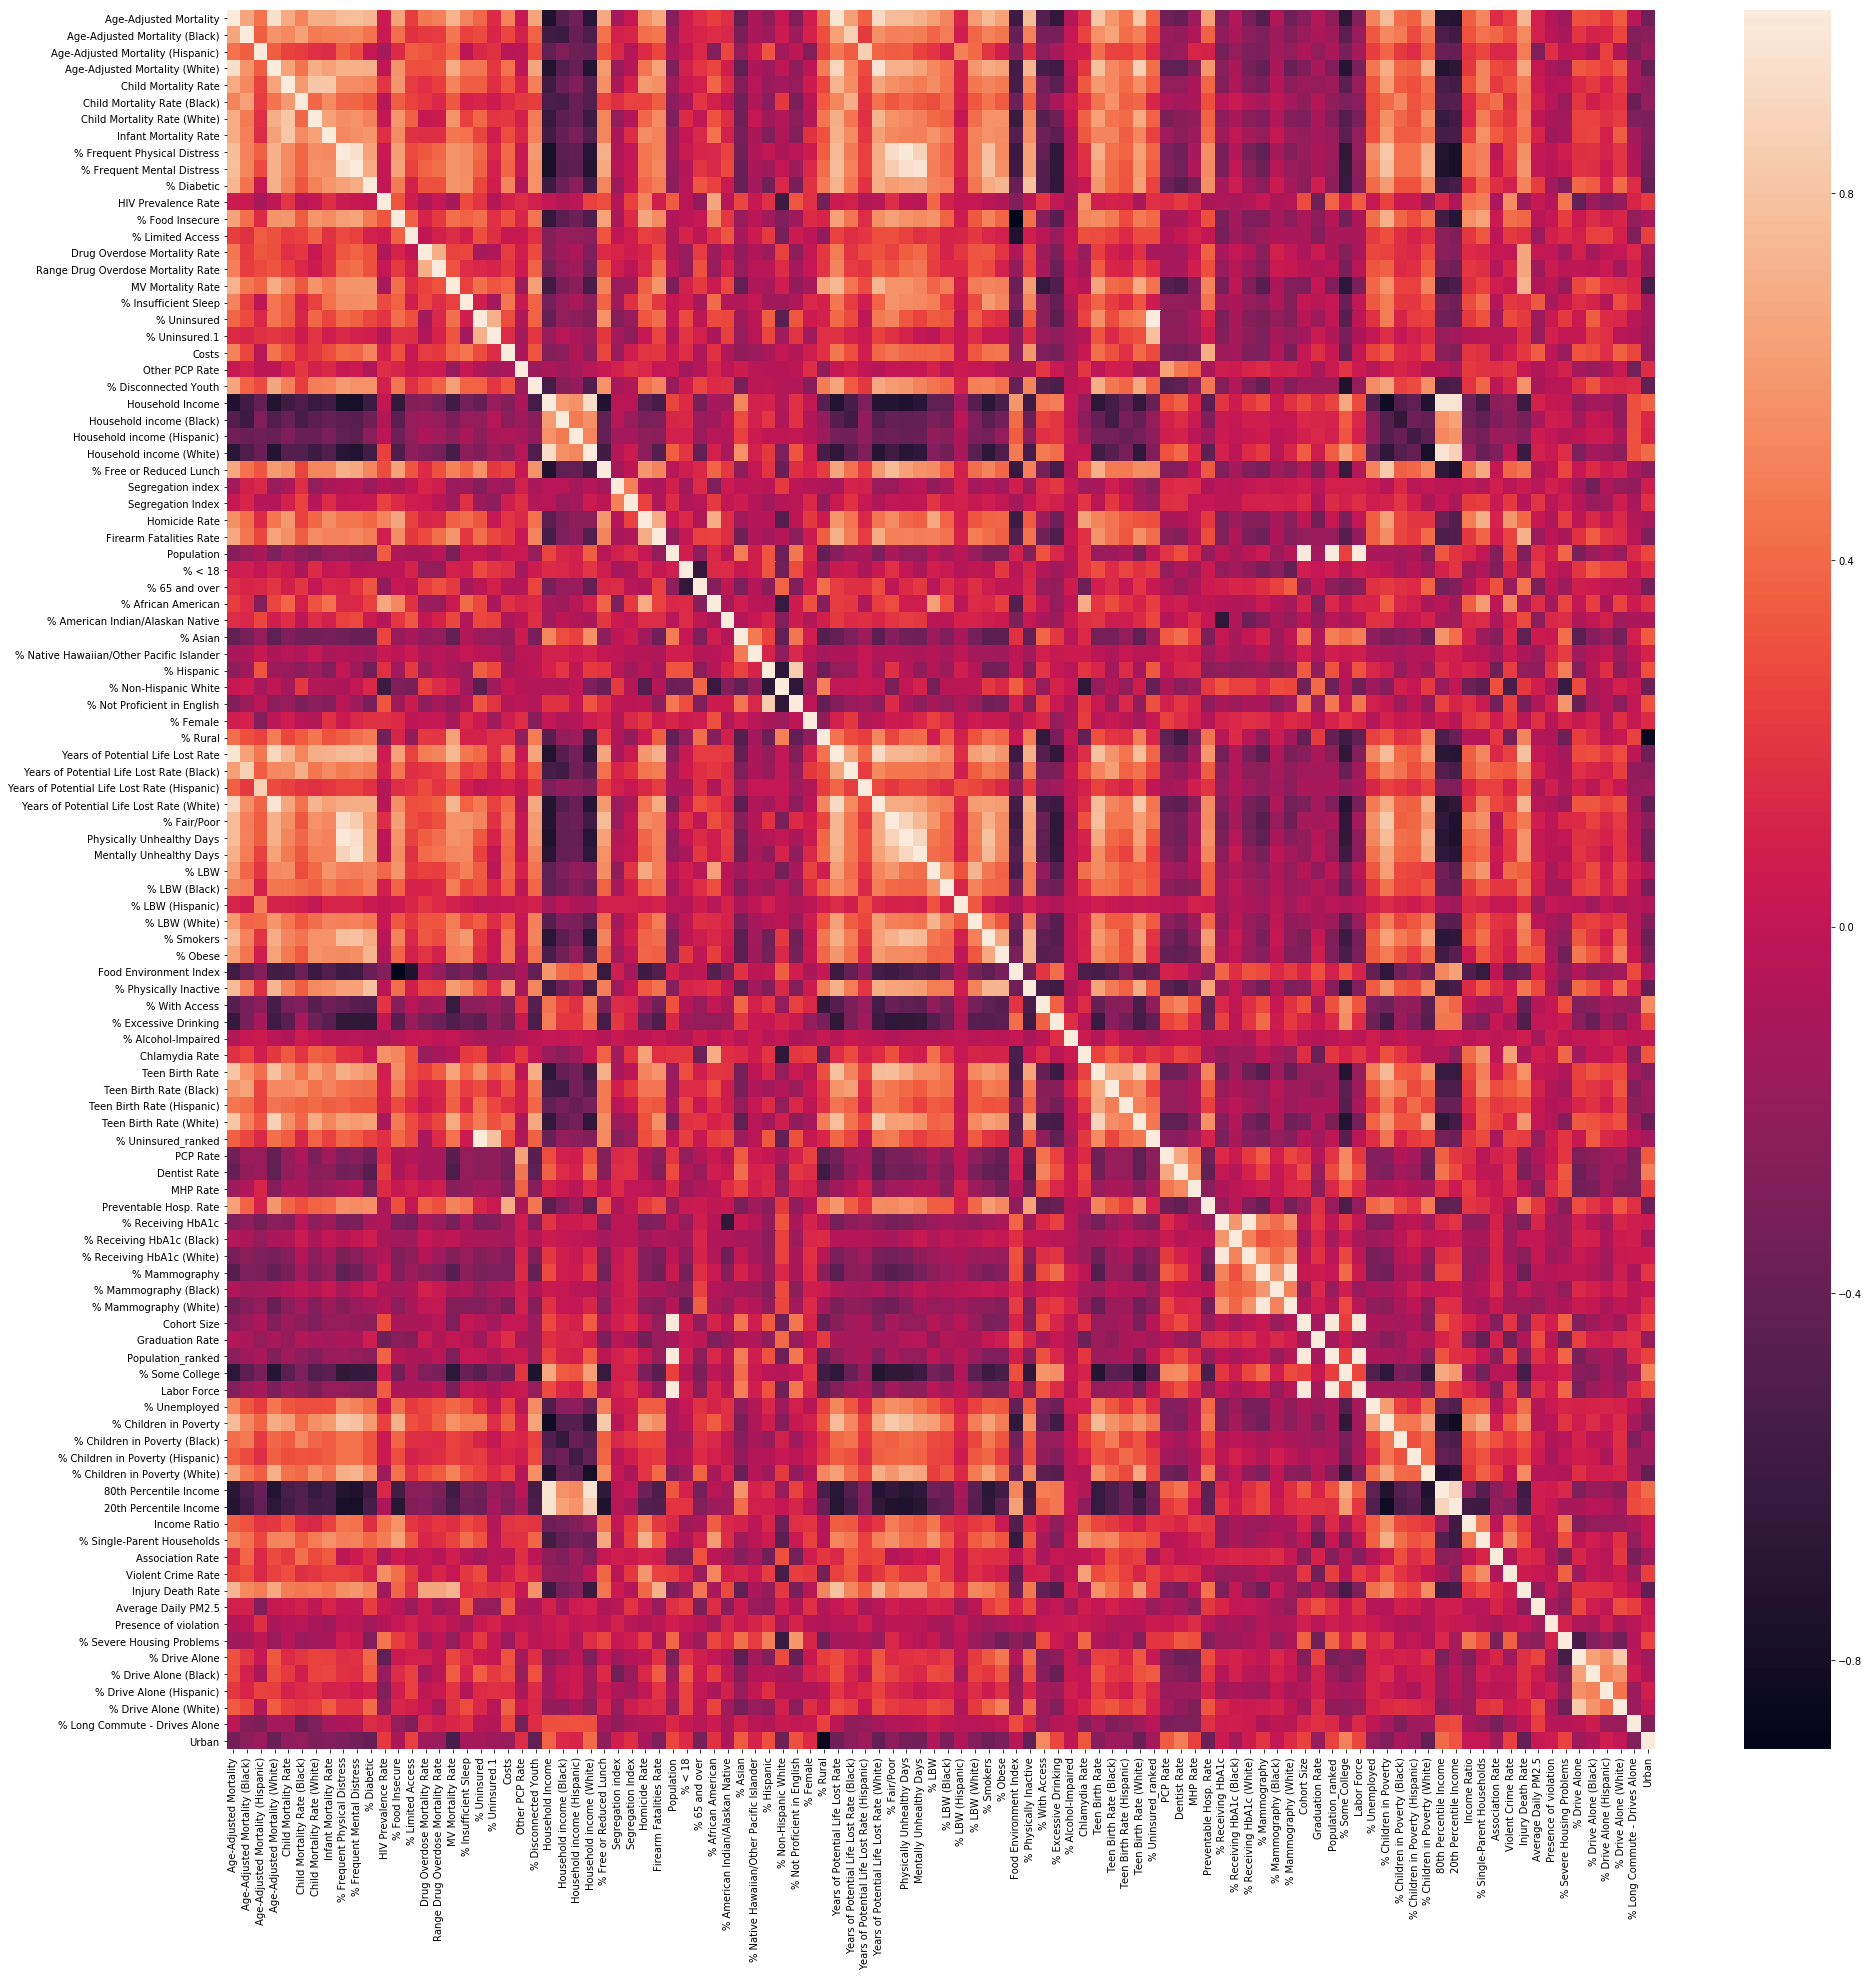

In [16]:
# Examine feature correlation using a heatmap
plt.figure(figsize=(32, 32))
sns.heatmap(data=counties.corr())
plt.show()

In [17]:
# 'Range Drug Overdose Mortality Rate' is a modeled rate and can be seen above
# to correlate strongly with actual, so we will use the actual only
counties = counties.drop(columns=['Range Drug Overdose Mortality Rate'])

In [18]:
# PCP Rate and PCP Ratio are redundant, rate is more useful
counties = counties.drop(columns=['PCP Ratio', 'Other PCP Ratio'])
# Same applies for Dentist Rate and Ratio
counties = counties.drop(columns=['Dentist Ratio'])
# Same applies for MHP Rate and Ratio (Mental Health Provider)
counties = counties.drop(columns=['MHP Ratio'])

### Impute Missing Values
Using a K-Nearest-Neighbors method, impute missing values for each feature with many missing values. The neighbors will be determined based on the columns with no missing data

In [19]:
# Look at which features are missing data
missing_counts = pd.DataFrame(counties.isna().sum())
missing_counts.columns = ['count']
missing_counts = missing_counts[missing_counts['count'] > 0]
missing_counts = missing_counts.sort_values(by='count')
missing_counts

,count
PCP Rate,1
Injury Death Rate,1
Other PCP Rate,2
Costs,2
% Receiving HbA1c,3
Preventable Hosp. Rate,3
% Mammography,4
Dentist Rate,4
Segregation Index,5
MV Mortality Rate,5


In [20]:
# See the features without missing data
counties.columns[counties.notna().all()]

Index(['State', 'County', 'Age-Adjusted Mortality',
       '% Frequent Physical Distress', '% Frequent Mental Distress',
       '% Diabetic', '% Food Insecure', 'Drug Overdose Mortality Rate',
       '% Insufficient Sleep', '% Uninsured', '% Uninsured.1',
       'Household Income', 'Population', '% < 18', '% 65 and over',
       '% African American', '% American Indian/Alaskan Native', '% Asian',
       '% Native Hawaiian/Other Pacific Islander', '% Hispanic',
       '% Non-Hispanic White', '% Not Proficient in English', '% Female',
       '% Rural', 'State_ranked', 'County_ranked',
       'Years of Potential Life Lost Rate', '% Fair/Poor',
       'Physically Unhealthy Days', 'Mentally Unhealthy Days', '% LBW',
       '% Smokers', '% Obese', '% Physically Inactive', '% With Access',
       '% Excessive Drinking', '% Alcohol-Impaired', 'Chlamydia Rate',
       'Teen Birth Rate', '% Uninsured_ranked', 'Population_ranked',
       '% Some College', 'Labor Force', '% Unemployed',
       '% 

In [21]:
# Choose which of those features to cluster on
# Subjective choice, also not including CI features or raw counts
impute_sources = ['% Frequent Physical Distress', '% Frequent Mental Distress',
       '% Diabetic', '% Food Insecure', '% Insufficient Sleep', 'Population', '% < 18',
       '% 65 and over', '% African American', '% American Indian/Alaskan Native',
       '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', 
       '% Non-Hispanic White', '% Not Proficient in English', '% Female', '% Rural']

In [22]:
# Fill in missing data using a K-Nearest-Neighbors approach
from sklearn.neighbors import KNeighborsRegressor 
def knn_imputer(df, sources, target, n_neighbors=5):
    X_train = (df[df[target].notna()])[sources]
    y_train = (df[df[target].notna()])[target]
    
    imp = KNeighborsRegressor(n_neighbors, weights='distance')
    imp.fit(X_train, y_train)
    imputed = imp.predict((df[df[target].isna()])[sources])
    
    res_df = df[df[target].isna()].copy()
    res_df[target] = imputed
    return res_df[[target]]

In [23]:
for feature in missing_counts.index.values:
    res_df = knn_imputer(counties, impute_sources, feature, 5)
    counties[feature] = counties[feature].fillna(value=res_df[feature].to_dict())

## Save our completed DataFrame to a pickle

In [24]:
counties.to_pickle('counties_df.pkl')
statewide.to_pickle('statewide_df.pkl')